Modified from the source article: https://github.com/eltontay/Ethereum-Fraud-Detection

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data/5_merging_dataset/dataset_main_full.csv')
df = df.fillna(0)

columns = [
    'Address',
    'tag',
    'FLAG',
    'Avg min between sent tnx',
    'Avg min between received tnx',
    'Time Diff between first and last (Mins)',
    'Sent tnx',
    'Received Tnx',
    'Number of Created Contracts',
    'Unique Received From Addresses',
    'Unique Sent To Addresses',
    'min value received',
    'max value received',
    'avg val received',
    # 'min val sent',
    'max val sent',
    'avg val sent',
    'min value sent to contract',
    # 'max val sent to contract',
    'avg value sent to contract',
    'total transactions (including tnx to create contract',
    # 'total Ether sent',
    'total ether received',
    'total ether sent contracts',
    'total ether balance',
    ' Total ERC20 tnxs',
    ' ERC20 total Ether received',
    ' ERC20 total ether sent',
    # ' ERC20 total Ether sent contract',
    ' ERC20 uniq sent addr',
    ' ERC20 uniq rec addr',
    # ' ERC20 uniq sent addr.1',
    # ' ERC20 uniq rec contract addr',
    ' ERC20 avg time between sent tnx',
    ' ERC20 avg time between rec tnx',
    # ' ERC20 avg time between rec 2 tnx',
    # ' ERC20 avg time between contract tnx',
    ' ERC20 min val rec',
    ' ERC20 max val rec',
    ' ERC20 avg val rec',
    # ' ERC20 min val sent',
    # ' ERC20 max val sent',
    ' ERC20 avg val sent',
    # ' ERC20 min val sent contract',
    # ' ERC20 max val sent contract',
    # ' ERC20 avg val sent contract',
    # ' ERC20 uniq sent token name',
    # ' ERC20 uniq rec token name',
    # ' ERC20 most sent token type',
    # ' ERC20_most_rec_token_type',
]

df = df[columns]

In [3]:
X = df.drop(columns=['Address', 'FLAG', 'tag'])
y = df['FLAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [4]:
scaler = MinMaxScaler()


def converter(x):
    if isinstance(x, (int, float)):
        return np.log(x) if x > 0 else 0
    return x

for c in columns:
    if c in X_train.columns:
        X_train[c] = X_train[c].apply(converter)
        X_test[c] = X_test[c].apply(converter)

# Scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
import joblib

joblib.dump(scaler, 'data/models/scaler.gz')
# my_scaler = joblib.load('data/models/scaler.gz')

['data/models/scaler.gz']

In [6]:
# params = {
#     'max_depth': range (2, 10, 1),
#     'n_estimators': range(1000,1500,100),
#     'learning_rate': [0.1, 0.01, 0.05]
# }

params = {
    'max_depth': [7],
    'n_estimators': [1300],
    'learning_rate': [0.1]
}

In [7]:
clf = XGBClassifier(
    objective='binary:logistic',
    seed=42,
    # tree_method="hist", device="cuda"  # IMPORTANT! Use when gpu available!
)

In [8]:
tuned_clf = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='f1',
    cv=5,
    verbose=2,
)

In [9]:
tuned_clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1300; total time=  23.3s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1300; total time=  24.1s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1300; total time=  19.9s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1300; total time=  20.6s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=1300; total time=  20.8s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [7],
                         'n_estimators': [1300]},
             scoring='f1', verbose=2)

In [10]:
print("Tuned Hyperparameters :", tuned_clf.best_params_)
print("Train F1 Score :", tuned_clf.best_score_)
best_y_pr = tuned_clf.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1300}
Train F1 Score : 0.9704028444822985
Test F1 Score:  0.9714497340246449


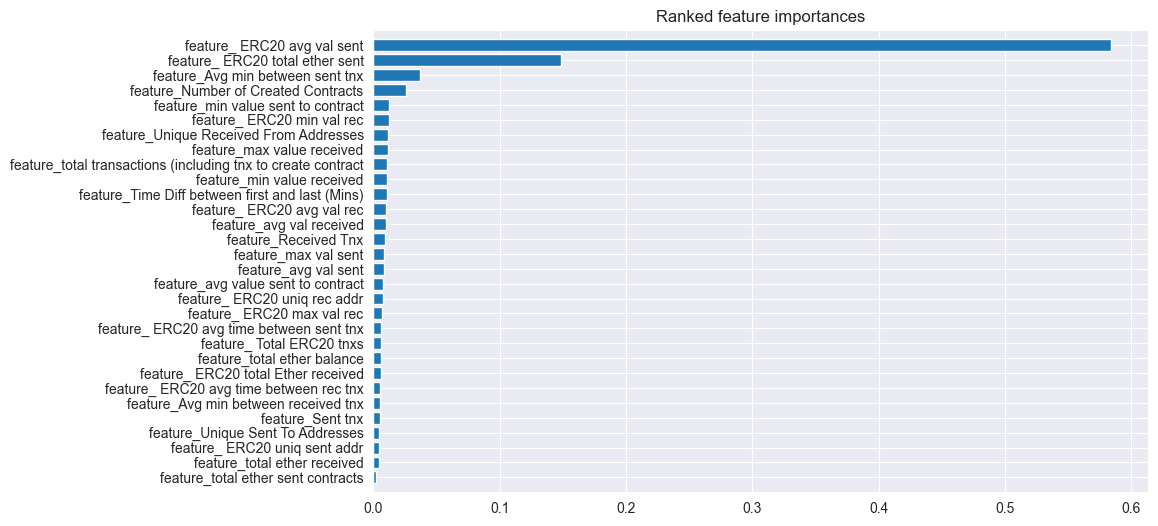

In [11]:
from matplotlib import pyplot as plt

feat_importances = tuned_clf.best_estimator_.feature_importances_
indices = np.argsort(feat_importances)
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[3:][i]) for i in range(len(columns) - 3)]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [12]:
tuned_clf.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
tuned_clf.best_score_

0.9704028444822985

In [14]:
tuned_clf.best_estimator_.save_model("data/models/xgboost_model_1.json")

#### Testing model on data (custom usage example)

In [16]:
import xgboost as xgb

tuned_clf = xgb.Booster()
tuned_clf.load_model("data/models/xgboost_model_1.json")

In [17]:
y_pred = tuned_clf.predict(xgb.DMatrix(X_test))
y_pred = [int(i >= 0.5) for i in y_pred]

xgb_accuracy_score = accuracy_score(y_test, y_pred)
xgb_auc_score = roc_auc_score(y_test, y_pred)
print('XGBoost model accuracy score: {0:0.4f} '
      'and roc_auc score: {0:0.4f}'.format(xgb_accuracy_score, xgb_auc_score))

XGBoost model accuracy score: 0.9717 and roc_auc score: 0.9717


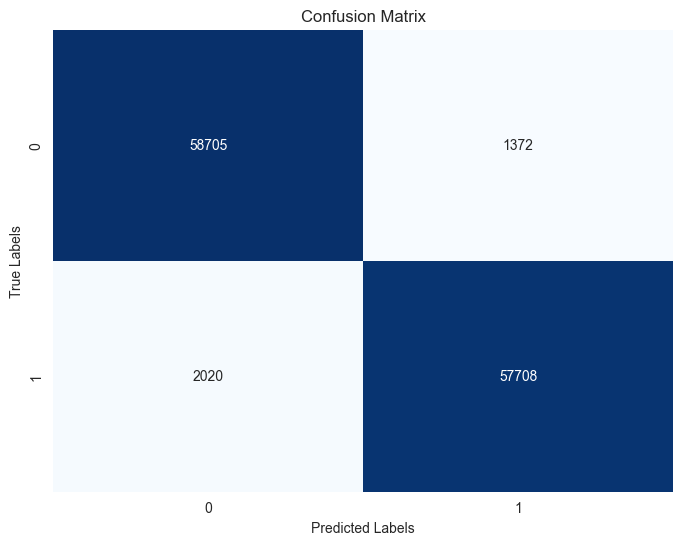

In [19]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()